<a href="https://colab.research.google.com/github/annasajkh/Face-Generator/blob/main/Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1h24QCVcxZUzMZGsaNXynRgktK4UHsETP

Downloading...
From: https://drive.google.com/uc?id=1h24QCVcxZUzMZGsaNXynRgktK4UHsETP
To: /content/face_model.pkl
52.8MB [00:00, 127MB/s] 


In [ ]:
from torch.nn.modules.linear import Linear
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(3, 120, kernel_size=3, stride=2, padding=1),
      nn.LeakyReLU(True),

      nn.Conv2d(120, 160, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(160),
      nn.LeakyReLU(True),

      nn.Conv2d(160, 200, kernel_size=3, stride=2, padding=0),
      nn.LeakyReLU(True),

      nn.Flatten()
    )

    self.fc1 = nn.Sequential(
      nn.Linear(9800, 600),
      nn.LeakyReLU(True)
    )

    self.fc2 = nn.Sequential(
      nn.Linear(300, 600),
      nn.LeakyReLU(True),

      nn.Linear(600, 9800),
      nn.LeakyReLU(True)
    )


    self.decoder = nn.Sequential(      
      nn.ConvTranspose2d(200, 160, kernel_size=3, stride=2, output_padding=0),
      nn.BatchNorm2d(160),
      nn.ReLU(True),

      nn.ConvTranspose2d(160, 120, kernel_size=5, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(120),
      nn.ReLU(True),

      nn.ConvTranspose2d(120, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )
  
  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample

  def forward(self, x):
    #code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

    x = self.encode(x).view(-1, 2, 300)

    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    x = self.decode(z)
    return x, mu, log_var
  
  def encode(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x

  def decode(self, x):
    x = self.fc2(x)
    x = x.view(x.shape[0], 200, 7, 7)
    x = self.decoder(x)
    return x

#code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
model = AutoEncoder()
model.load_state_dict(torch.load("face_model.pkl", map_location=torch.device("cpu")))

<All keys matched successfully>

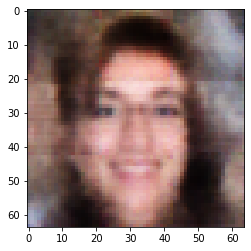

In [ ]:
generated_face = model.decode(torch.randn(1, 300))
plt.imshow(generated_face.cpu().detach().reshape(64, 64, 3))